In [83]:
import os
import json
import numpy as np
import networkx as nx
import tqdm as tqdm
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

import matplotlib.pyplot as plt
from networkx.drawing.layout import *


In [84]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14

Find the ER for the MPC, MPG, and SP protocols

In [85]:
# size = 5
# G =  network(size,size) # i.e. 6 x 6 networkx graph
# nodes = list(G.nodes)

In [86]:
def load_data(filename):
    file_path = os.path.abspath(os.path.join(os.getcwd(), "../graphs_json/", f"{filename}.json"))
    with open(file_path, "r") as file:
        return json.loads(file.read())

In [87]:
data = load_data("TOP_1_ABILENE_reordered")
G = nx.node_link_graph(data)
G = network(G)
nodes = list(G.nodes)

funcs= [MPC_protocol,MPG_protocol,SP_protocol]
p_range = np.linspace(1, 0.2, 50)
ER = np.zeros((len(funcs),len(p_range)))
timesteps = 100
reps = 200

users = [node["id"] for node in data["nodes"]]
print(users)
#users = [(2, 2), (0, 0), (0, 4), (4, 0), (4, 4)]

for i,p in enumerate(tqdm.tqdm(p_range)):# tqdm_notebook
    set_p_edge(G,p_op = p)
    # print(p)
    for j,function in enumerate(funcs):
        er,multipartite_gen_time, links_used = function(G,users,timesteps=timesteps,reps=reps)
        ER[j,i]+=er
        # if function == MPC_protocol:
        #     print(f"MPC_protocol: {er}")
        # elif function == MPG_protocol:
        #     print(f"MPG_protocol: {er}")
        # elif function == SP_protocol:
        #     print(f"SP_protocol: {er}")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


## plot Figure

<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Aaron\AppData\Local\Temp\ipykernel_12584\3455742607.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)


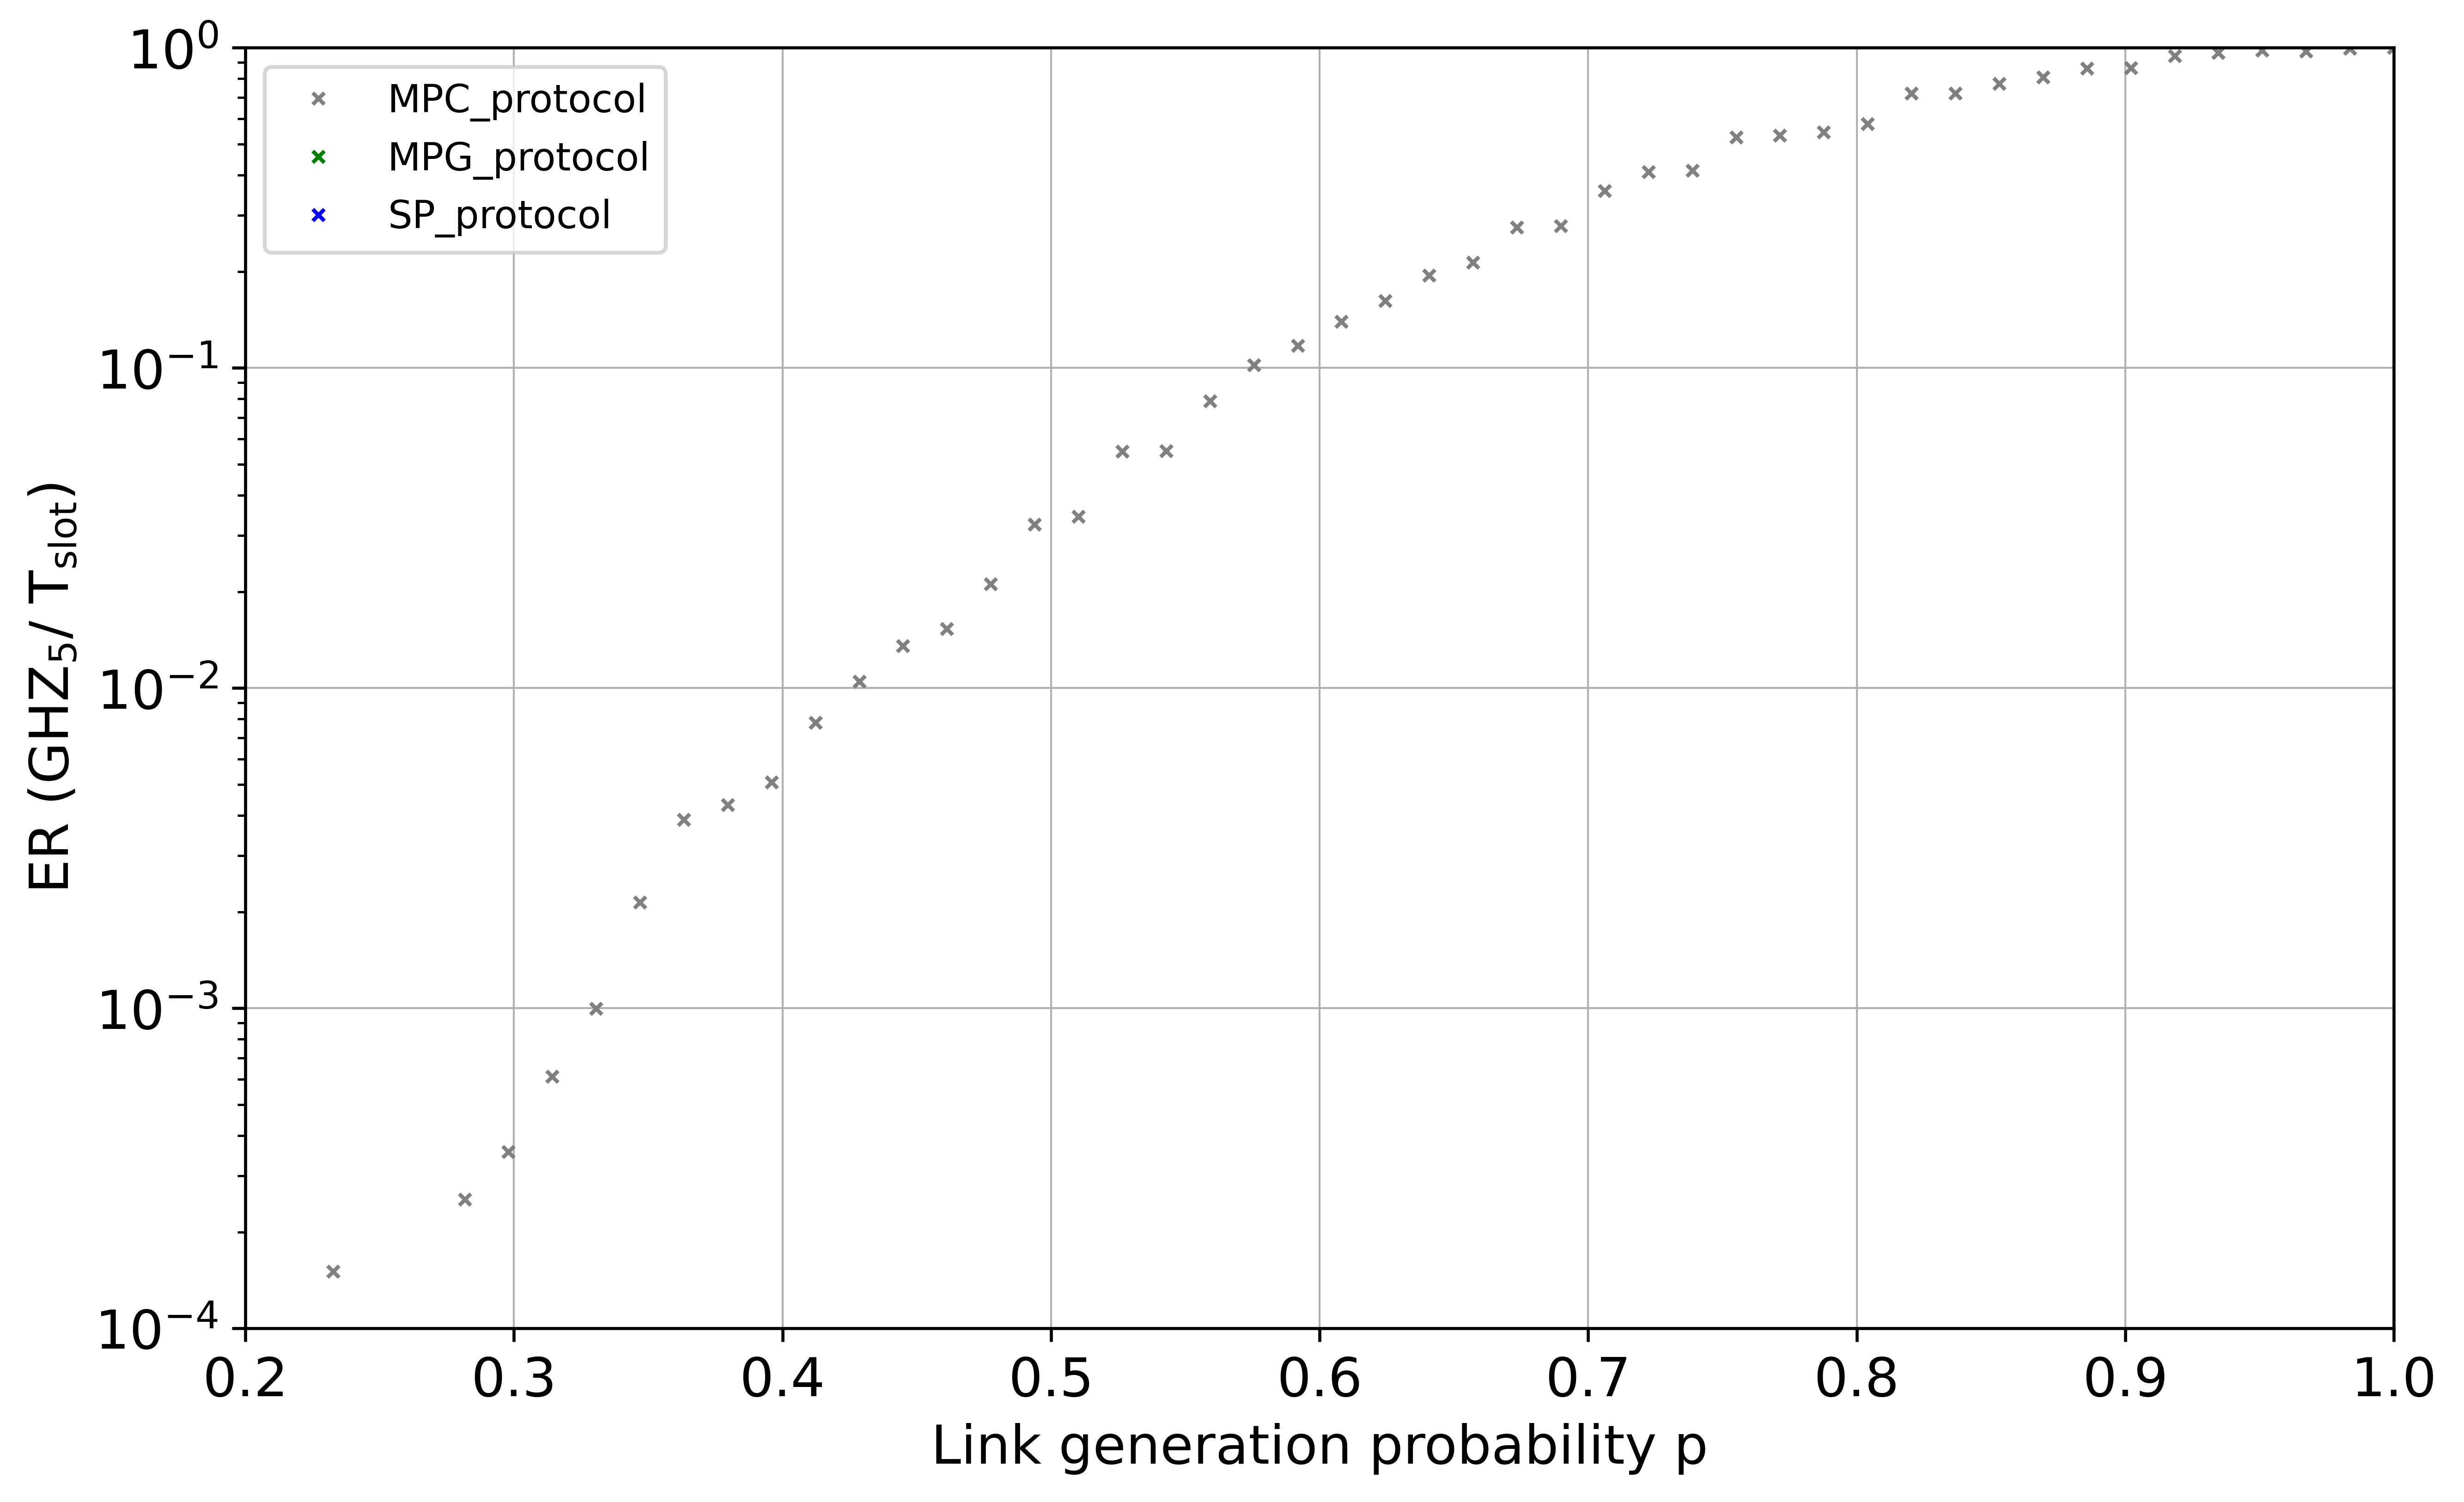

In [88]:
p_range = np.linspace(1, 0.2, 50) # xpoints
nom_list = [str(f).split(' ')[1] for f in funcs]
plt.figure(figsize =(10,6),dpi=600 )
plt.grid(linewidth=0.5)
for i in range(len(funcs)):
    y = plt.plot(p_range, ER[i],
                 color = cols[i],
                 marker = "x",
                 linestyle='None',
                 markersize = 3,
                #  alpha = 0.5,
                #  linewidth=linewidth,
                 label = nom_list[i])
plt.yscale('log')
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel('Link generation probability p',fontsize=fontsize)
plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0.2, 1])
ax.set_ylim([0.0001, 1])

plt.savefig("../figures/ER_v_p.png", dpi=600)